<center><b>EE 538 Spring 2021<br>
Low-Noise Analog Circuit Design<br>
University of Washington Electrical & Computer Engineering</b></center>


<b>Instructor: Jason Silver<br>
Assignment #1 (10 points)<br>
Due Sunday, April 11 (Submit on Canvas as a Jupyter Notebook)</b> 

*Please show your work*

Resources: 

https://analog.intgckts.com/equivalent-noise-bandwidth/#:~:text=Equivalent%20Noise%20Bandwidth%201%20comment&text=Equivalent%20noise%20bandwidth(ENBW)%20is,bandwidth%20or%20effective%20noise%20bandwidth.&text=or%20magnitude%20of%20brickwall%20filter%20in%20passband

http://www.onmyphd.com/?p=enbw.equivalent.noise.bandwidth

https://www.k-state.edu/edl/docs/pubs/technical-resources/Technote1.pdf

http://web.engr.oregonstate.edu/~webbky/ENGR202_files/SECTION%203%20Second%20Order%20Filters.pdf

https://www.ti.com/lit/an/sloa049b/sloa049b.pdf?ts=1617717745044&ref_url=https%253A%252F%252Fwww.google.com%252F

In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

In [2]:
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

<b>Problem 1: Noise bandwidth

The transfer function of a second-order low-pass filter can be written as

\begin{equation}
H(s)={\frac {\omega _{0}^{2}}{s^{2}+2\zeta \omega _{0}\cdot s+\omega _{0}^{2}}}
\end{equation}

where $\omega_0$ is the resonant frequency and $\zeta$ is the damping factor.

<u>*Analysis*</u>

<hr>

__a)__ Derive a general expression for the noise bandwidth of a second-order low-pass filter.

<hr>

$\begin{eqnarray}
H(s)  &=& {\frac {\omega _{0}^{2}}{s^{2}+2\zeta \omega _{0}\cdot s+\omega _{0}^{2}}} \\[2pt]
      &=& {\frac {\omega _{0}^{2}}{s^{2}+\frac{s\cdot\omega_0}{Q}+\omega _{0}^{2}}} \\[2pt]
      &=& {\frac {1}{\frac{s^{2}}{\omega_0^2}+\frac{s}{Q\omega_0}+1}} \\[2pt]
      &=& {\frac {1}{\frac{(j\omega)^{2}}{\omega_0^2}+\frac{(j\omega)}{Q\omega_0}+1}} \\[2pt]
      &=& {\frac {1}{\frac{-\omega^2}{\omega_0^2}+\frac{j\omega}{Q\omega_0}+1}} \\[3pt]
|H(s)|&=& {\frac {1}{\sqrt{(1+\frac{-\omega^2}{\omega_0^2})^2+(\frac{\omega}{Q\omega_0})^2}}} &\text{and Butterworth }& Q=\frac{1}{\sqrt2} \\[2pt]
      &=& {\frac {1}{\sqrt{1-\frac{2\omega^2}{\omega_0^2}+\frac{\omega^4}{\omega_0^4}+\frac{\omega^2}{Q^2\omega_0^2}}}} \\[2pt]
      &=& {\frac {1}{\sqrt{1-\frac{2\omega^2}{\omega_0^2}+\frac{\omega^4}{\omega_0^4}+\frac{2\omega^2}{\omega_0^2}}}} \\[2pt]
      &=& {\frac {1}{\sqrt{1+\frac{\omega^4}{\omega_0^4}}}} \\[2pt]
      &=& {\frac {1}{\sqrt{1+(\frac{\omega}{\omega_0})^4}}} &\text{and Butterworth }& \omega_0 = \omega_c \\[2pt]
      &=& {\frac {1}{\sqrt{1+(\frac{\omega}{\omega_c})^4}}} \\[3pt]
\omega_{enb} &=& \int_{0}^\infty \displaystyle\left\lvert{H(s)}\right\rvert^2\ d\omega \\[2pt]
  &=& \int_{0}^\infty \frac{1}{1+(\frac{\omega}{\omega_c})^4}\ d\omega \\[3pt]
f_{enb} &=& \frac{1}{2\pi} \int_{0}^\infty \frac{1}{1+(\frac{\omega}{\omega_c})^4}\ d\omega
\end{eqnarray}$

<hr>

__b)__ Using your expression from part __a__, determine the relationship between the noise bandwidth and the $-3\text{dB}$ bandwidth of a second-order Butterworth filter.

<hr>

$\begin{eqnarray}
f_{enb} &=& \frac{1}{2\pi} \int_{0}^\infty \frac{1}{1+(\frac{\omega}{\omega_{c}})^4}\ d\omega \\[3pt]
        && \text{let } x=\frac{\omega^4}{{\omega_c}^4} \\[3pt]
        &=& \frac{1}{2\pi} \int_{0}^\infty \frac{1}{1+x^4} dx \cdot \omega_c  \\[3pt]
        &=& \frac{\omega_c}{2\pi} \cdot \frac{\pi}{2\sqrt{2}} \\[3pt]
        &=& \frac{2\pi f_c}{2\pi} \cdot \frac{\pi}{2\sqrt{2}} \\[3pt]
        &=& \frac{\pi}{2\sqrt{2}} f_c \\[3pt]
        &\approx& 1.11 f_c
\end{eqnarray}$

<u>*Design*</u>

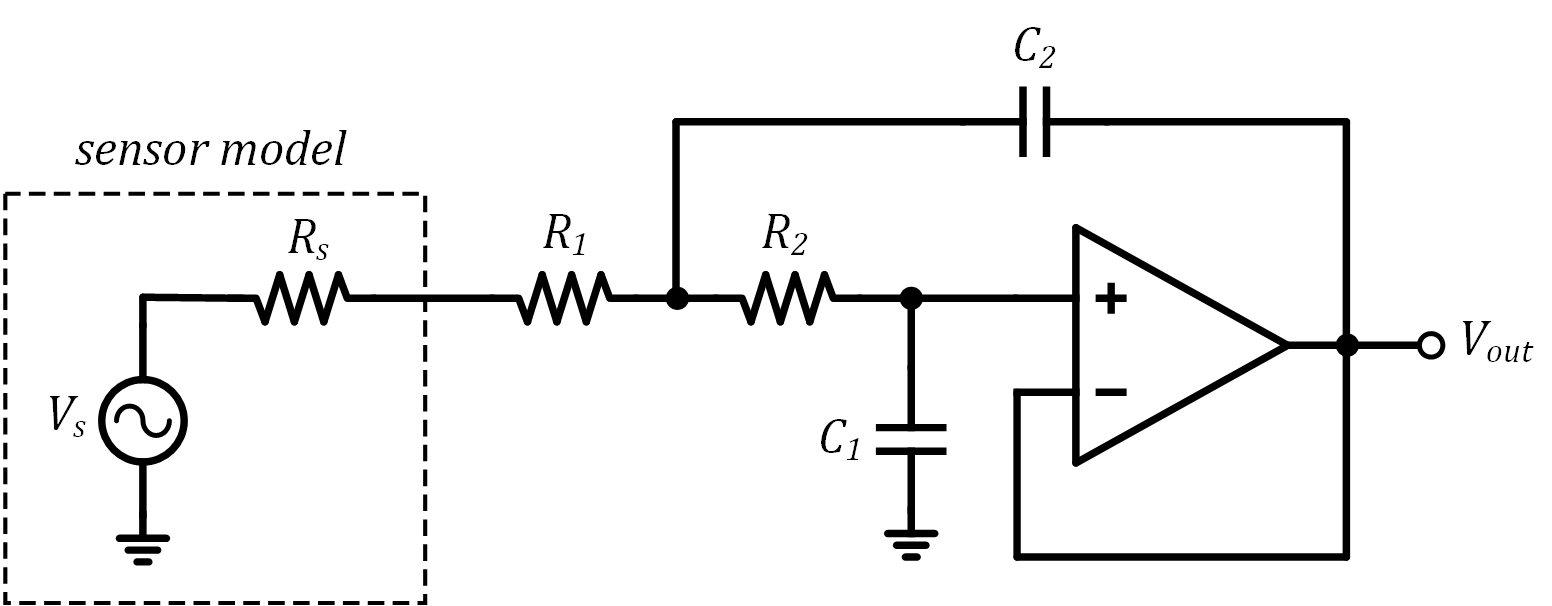

<hr>

__c)__ Using the Sallen-Key structure shown above, design an active second-order Butterworth filter (i.e. determine $R$ and $C$ values) to limit the noise bandwidth of a resistive sensor with equivalent resistance $R_s = 1\text{k}\Omega$. Design the filter to achieve an input-referred $rms$ noise of $40\text{nV}$. Assume that the opamp and filter resistors are noiseless.

<hr>

$\begin{eqnarray}
T &=& 25C = 298 K \\
k &=& 1.381 \cdot 10^{−23} \\
R_s &=& 1000
\end{eqnarray}$

$\begin{eqnarray}
v_{n,out(\text{rms})} &=& \sqrt{e_{n}^2 \cdot f_{enb}} \\[0.5em]
v_{n,in(\text{rms})} &=& \frac{v_{n,out(\text{rms})}}{A_{v,CL}} \text{ where } A_{v,CL}=1 \\[0.5em]
v_{n,in(\text{rms})} &=& v_{n,out(\text{rms})} \\[0.5em]
40 \text{nV}  &\geq& \sqrt{e_n^2 \cdot f_{enb}}  \\[0.5em]
e_n^2 \text{ } &=& {4kTR_{s}} \\[0.5em]
 &=& 1.6458 \cdot 10^{-17} \frac{V^2}{\text{Hz}} \\[0.5em]
40 \text{nV}  &\geq& \sqrt{1.6458 \cdot 10^{-17} \cdot f_{enb}}  \\[0.5em]
f_{enb} &\leq& \frac{(40 \text{nV})^2}{1.6458 \cdot 10^{-17}} \\[0.5em]
1.11 f_{c} &\leq& \frac{(40 \text{nV})^2}{1.6458 \cdot 10^{-17}} \\[0.5em]
f_{c} &\leq& \frac{(40 \text{nV})^2}{1.6458 \cdot 10^{-17} \cdot 1.11} \\[0.5em]
f_c &\leq& 87.6 \text{Hz}
\end{eqnarray}$

In [3]:
T = 298
k = 1.381 * 1e-23
Rs= 1000
target = 40*1e-9
Vrms = np.sqrt(4*k*T*Rs)
fenb = target**2/Vrms**2
fc = fenb/1.11
print(f'fc: {round(fc,4)}, and f_enb: {round(fenb,4)}')

fc: 87.5643, and f_enb: 97.1964


In [4]:
s,m,n,C1,C2,R1,R2,Q,tau,W0,Wc,Cn,K = sp.symbols('s,m,n,C1,C2,R1,R2,Q,tau,omega0,Wc,Cn,K')

In [5]:
# Low Pass Butterworth
fc1 = 87
systemLP = sp.Matrix([
    [W0 - 1/(tau*sp.sqrt(m*n))],
    [W0 - Cn*Wc],
    [Q - sp.sqrt(m*n)/(1+m)],
    [m - R1/R2],
    [n - C1/C2],
    [tau - R2*C2]
])
myVals = {
    W0:2*np.pi*fc1,  # Cutoff Frequency in radians/second
    Cn:1,            # Table 
    Q:1/np.sqrt(2),  # Table 
    m:1,             # Chosen Ratio
    C2:10e-9         # Chosen Value 
}
systemLP = systemLP.subs(myVals)
eq = sp.solve(systemLP)
eq, myVals

({C1: 2.00000000000000e-8,
  R1: 129355.792551308,
  R2: 129355.792551308,
  n: 2.00000000000000,
  tau: 0.00129355792551308,
  Wc: 546.637121724624},
 {omega0: 546.637121724624, Cn: 1, Q: 0.7071067811865475, m: 1, C2: 1e-08})

In [6]:
f = np.logspace(-2, 4, 10000)
w = 2*np.pi*f
#s = 1j*w

num = W0**2
den = s**2 + s*W0/Q + W0**2

components = {
    #C1:20e-9,
    #C2:10e-9,
    #R1:129356,
    #R2:129356,
    W0:546,
    Q :1/np.sqrt(2)    
}
H = sp.Matrix([num/den])
H1 = H = H.subs(components)
H = lambdify(s,H,modules='numpy')
H = H(1j*w)
H = H[0][0]

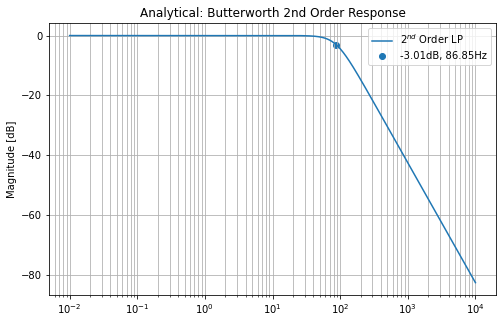

In [7]:
fig, ax = plt.subplots(figsize=(8,5))

x1 = np.where(20*np.log10(abs(H))<=-3)[0][0]
label1 = "{:.2f}dB, {:.2f}Hz".format(20*np.log10(abs(H[x1])),f[x1])

ax.set_title('Analytical: Butterworth 2nd Order Response')
ax.semilogx(f, 20*np.log10(abs(H)),label=r'$2^{nd}$ Order LP')
ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
ax.set_ylabel('Magnitude [dB]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

<hr>

__d)__ Verify your design in Ltspice using the *UniversalOpamp2* model with a bandwidth of $10\text{MHz}$. Demonstrate the frequency response and noise performance over a frequency range of $100\text{MHz}$, and verify that the $rms$ noise meets the specification by integrating over the full $100\text{MHz}$ range.

<hr>

<img src="images/butterworth_2nd_order_LP.PNG" width="600">

In [8]:
filepath = 'data/butterworth_2nd_order_LP.txt'
df = pd.read_csv(filepath)
freq = df['frequency']
mag = df['V(onoise)']

No handles with labels found to put in legend.


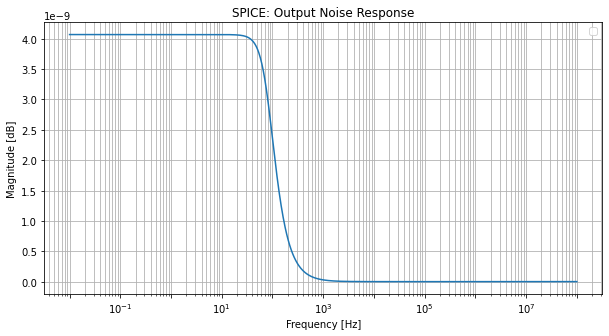

In [9]:
fig, ax = plt.subplots(1,figsize=(10,5))

ax.semilogx(freq, mag, color='tab:blue',label='')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_title('SPICE: Output Noise Response')

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.legend()
plt.show();

<img src="images/V(onoise).PNG" width="300">

Input noise can be determined from the output noise based on the amplifier gain. Refer to part C. In our case, the input-referred rms noise is equivalent to the output rms noise. The design of the LP Butterworth meets the spec of 40nV.

<hr>

__e)__ If the sensor exhibits $1/f$ noise, the spectral density of the noise can be expressed as

\begin{equation}
\overline{e_n^2} = 4kTR_s\cdot\left(1+\dfrac{f_c}{f}\right)\Delta f
\end{equation}

where $f_c$ is the $1/f$ noise corner frequency. Determine the $rms$ noise (at the output of the filter) between $1\text{Hz}$ and $1\text{MHz}$ if $f_c = 1\text{kHz}$.  Verify this in Ltspice. Explain why the concept of noise bandwidth doesn't apply to noise processes that aren't white.

<hr>

 From notes:
 
 - The equivalent noise bandwidth ($f_{enb}$) of a circuit is the bandwidth of an ideal "brick-wall" filter that would result in the same $rms$ noise as the real filter
 
 - Because white noise has a flat (constant-value) spectrum, multiplication of $e_n$ by the noise bandwidth will conveniently yield the same $rms$ noise value as that obtained via integration of the filter magitude response

My response:

Since the spectral density function is no longer constant, due to 1/f noise, the noise bandwidth cannot simply be multiplied and must be calculated over the integral.

$\begin{eqnarray}
\overline{e_n^2} &=& 4kTR_s\cdot\left(1+\dfrac{f_c}{f}\right)\Delta f \\[0.5em]
{v_{n,out(\text{rms})}}^2 &=& \int_{1}^{1MHz} |H(f)|^2 e_n^2\ df \\[0.5em]
{v_{n,out(\text{rms})}} &=& \sqrt{\int_{1}^{1MHz} |H(f)|^2 e_n^2\ df} \\[0.5em]
  &=& \sqrt{\int_{1}^{1MHz} \frac{1}{1+(\frac{f}{f_{c_1}})^4}\cdot 4kTR_s\cdot\left(1+\dfrac{f_{c_2}}{f}\right)\ df} \\[0.5em]
  &=& \sqrt{\int_{1}^{1MHz} \frac{1}{1+(\frac{f}{88})^4}\cdot 4kT\cdot 1000 \cdot\left(1+\dfrac{1000}{f}\right)\ df} \\[0.5em]
  &=& 274.4 \text{ nV}
\end{eqnarray}$

<img src="images/butterworth_and_1_over_f_noise.PNG" width="600">

In [10]:
filepath = 'data/butterworth_and_1_over_f_noise.txt'
df = pd.read_csv(filepath)
freq = df['frequency']
mag = df['V(onoise)']

No handles with labels found to put in legend.


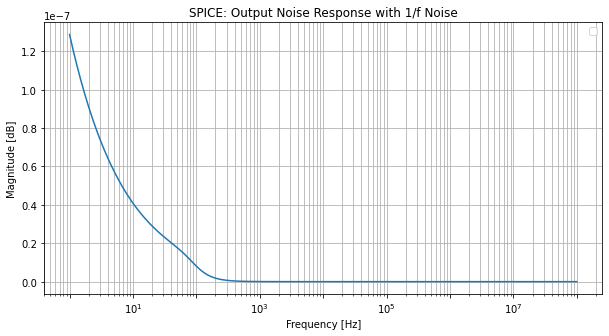

In [11]:
fig, ax = plt.subplots(1,figsize=(10,5))

ax.semilogx(freq, mag, color='tab:blue',label='')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_title('SPICE: Output Noise Response with 1/f Noise')

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.legend()
plt.show();

<img src="images/V(onoise)_1_over_f_noise.PNG" width="300">

*Use the expression 'noiseless' after the resistance value in Ltspice to prevent specific resistors from generating noise during noise analysis.* 

*To avoid loading between the sensor and filter input, you can use the 'E' component in Ltspice (voltage-controlled voltage source).* 